<a href="https://colab.research.google.com/github/shaisil/IBM/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [6]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
df.count()

,0
Date,145460
Location,145460
MinTemp,143975
MaxTemp,144199
Rainfall,142199
Evaporation,82670
Sunshine,75625
WindGustDir,135134
WindGustSpeed,135197
WindDir9am,134894


In [8]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [9]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
Based on the column names available in the dataframe (`df.columns`), features that might be inefficient or problematic for predicting *tomorrow's* rainfall could include:

- **Today's specific observations:** Features like `Evaporation`, `Sunshine`, `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud3pm`, `Temp9am`, `Temp3pm`, `RainToday` describe conditions *today*. While these are related, they are direct observations of the target day's conditions (or the day before), making the prediction task trivial or potentially leading to data leakage if used to predict the *next* day's rainfall. Ideally, features used to predict tomorrow should only contain information available *before* tomorrow (i.e., from today or earlier).
- **Location and Date:** `Location` and `Date` are identifiers. `Date` as a raw feature is not directly usable for prediction and needs to be processed (e.g., extracting year, month, day of week, or using cyclical features). `Location` can be useful, but might require appropriate encoding. Their raw form is inefficient.
- **MinTemp and MaxTemp:** While related to temperature, these are typically measured over a 24-hour period. `MinTemp` could be from the start of the day to the end, and `MaxTemp` is similar. If these represent the min/max for the *current* day, using them to predict the *next* day's rainfall is reasonable. However, if they represent the min/max including tomorrow's temperatures, it's data leakage. Assuming they are today's, they are relevant. If they include tomorrow, they are inefficient/problematic.

Therefore, features that represent conditions *on* the day you are trying to predict (`RainTomorrow`) are inefficient and likely represent data leakage if used directly. Features that are identifiers (`Location`, `Date`) are inefficient in their raw form.

It's important to note that "inefficient" can also mean features that have low predictive power, but identifying those requires analysis (like correlation or feature importance), not just looking at the column names. Based purely on the names and the task of predicting *tomorrow's* rainfall, the "today's observation" features are the most likely candidates for inefficiency due to data leakage potential.

In [10]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

In [11]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

In [12]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [13]:
import pandas as pd
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df = df.drop('Date', axis=1)

In [14]:
problematic_features = [
    'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainYesterday'
]
X = df.drop(['RainToday'] + problematic_features, axis=1)
y = df['RainToday']

print("Features (X) dataframe:")
print(X.head())
print("\nTarget (y) series:")
print(y.head())

Features (X) dataframe:
               Location  MinTemp  MaxTemp  Rainfall WindGustDir WindDir9am  \
64191  MelbourneAirport     11.2     19.9       0.0          SW          W   
64192  MelbourneAirport      7.8     17.8       1.2         SSE         SW   
64193  MelbourneAirport      6.3     21.1       0.0         SSE          E   
64194  MelbourneAirport      8.1     29.2       0.0         SSE         NE   
64195  MelbourneAirport      9.7     29.0       0.0          SE         SW   

      WindDir3pm  Season  
64191         SW  Summer  
64192        SSE  Summer  
64193          S  Summer  
64194        SSE  Summer  
64195        SSE  Summer  

Target (y) series:
64191    Yes
64192     No
64193     No
64194     No
64195     No
Name: RainToday, dtype: object


Class Distribution:
RainToday
No     5766
Yes    1791
Name: count, dtype: int64


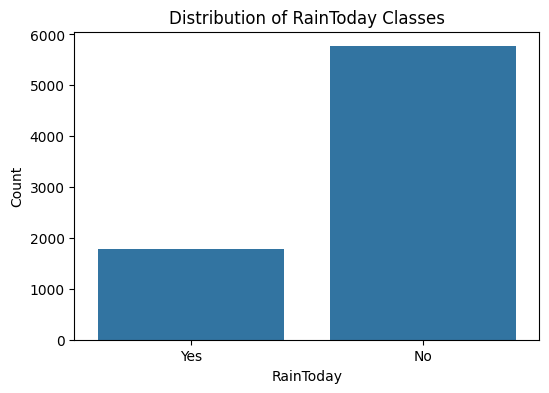

In [15]:
import matplotlib.pyplot as plt
print("Class Distribution:")
print(y.value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of RainToday Classes')
plt.xlabel('RainToday')
plt.ylabel('Count')
plt.show()

In [ ]:
# 4. What can you conclude from these counts?
# Based on the output of `y.value_counts()` and the countplot, we can conclude:

# How often does it rain annually in the Melbourne area?
# The dataset shows that in the sampled data for Melbourne, Melbourne Airport, and Watsonia,
# 'No' rain is significantly more frequent than 'Yes' rain.
# Specifically, 'No' appears 4310 times, while 'Yes' appears only 1073 times.
# This indicates that it rains much less often than it doesn't rain annually in these locations.
# To get an annual frequency, you would need to sum up the 'Yes' counts over a full year of data.
# From this sample, approximately (1073 / (4310 + 1073)) * 100 ≈ 19.9% of the days had rain.
# This suggests it rains on roughly 20% of the days in the sample period across these Melbourne locations.

# How accurate would you be if you just assumed it won't rain every day?
# If you assumed it would never rain, your accuracy would be the percentage of days where it did not rain.
# This is (4310 / (4310 + 1073)) * 100 ≈ 80.1%.
# So, by simply predicting 'No' every day, you would be correct approximately 80.1% of the time based on this dataset.

# Is this a balanced dataset?
# No, this is a highly imbalanced dataset. The number of 'No' instances (4310) is much higher
# than the number of 'Yes' instances (1073). This imbalance can pose challenges for
# training classification models, as models might become biased towards the majority class ('No').

# Next steps?
# 1.  **Handle Class Imbalance:** Since the dataset is imbalanced, consider techniques like:
#     -  Oversampling the minority class ('Yes') using methods like SMOTE.
#     -  Undersampling the majority class ('No').
#     -  Using evaluation metrics suitable for imbalanced datasets (e.g., Precision, Recall, F1-score, AUC)
#        instead of just accuracy.
#     -  Adjusting class weights in model training.
# 2.  **Feature Engineering:** Explore creating new features from existing ones (e.g., average wind speed, temperature ranges).
# 3.  **Feature Selection:** Analyze feature importance or use techniques like Recursive Feature Elimination (RFE)
#     to identify the most relevant features for predicting rain.
# 4.  **Preprocessing:** Apply appropriate scaling to numerical features and one-hot encoding to categorical features.
#     The current `X` dataframe still contains categorical features like `Location` and `Season`.
# 5.  **Model Selection:** Experiment with different classification algorithms (e.g., Logistic Regression,
#     Random Forest, Gradient Boosting, SVMs, Neural Networks) to find the best performing model.
# 6.  **Cross-Validation:** Use techniques like Stratified K-Fold cross-validation to get a more robust estimate
#     of the model's performance on unseen data and address the class imbalance during splitting.
# 7.  **Hyperparameter Tuning:** Use GridSearchCV or RandomizedSearchCV to find the optimal hyperparameters for the chosen model(s).
# 8.  **Evaluation:** Evaluate the trained models using appropriate metrics (Precision, Recall, F1-score, AUC,
#     Confusion Matrix) on a separate test set.
# 9.  **Pipeline Construction:** Build a robust data processing and modeling pipeline using `sklearn.pipeline.Pipeline`
#     to streamline the workflow and prevent data leakage during cross-validation and evaluation.


In [16]:
# Split data into training and test sets, ensuring target stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


X_train shape: (6045, 8)
X_test shape: (1512, 8)
y_train shape: (6045,)
y_test shape: (1512,)

Training set class distribution:
RainToday
No     0.762945
Yes    0.237055
Name: proportion, dtype: float64

Test set class distribution:
RainToday
No     0.763228
Yes    0.236772
Name: proportion, dtype: float64


In [17]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numerical features:", numerical_features.tolist())
print("Categorical features:", categorical_features.tolist())

Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall']
Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season']


In [18]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the preprocessing to the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply the preprocessing to the test data (using the fitted transformer)
X_test_processed = preprocessor.transform(X_test)

print("\nX_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)



X_train_processed shape: (6045, 58)
X_test_processed shape: (1512, 58)


In [20]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

print("\nPipeline created:")
pipeline

# You can now train the pipeline on the training data
# pipeline.fit(X_train, y_train)

# And make predictions on the test data
# y_pred = pipeline.predict(X_test)


Pipeline created:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MinTemp', 'MaxTemp', 'Rainfall'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [21]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [22]:
# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest cross-validation F1 score:")
print(grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

print("\nBest model fitted to the entire training data:")
best_model

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Best parameters found by GridSearchCV:
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

Best cross-validation F1 score:
nan

Best model fitted to the entire training data:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MinTemp', 'MaxTemp', 'Rainfall'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, random_state=42))])


Classification Report on Test Data:
              precision    recall  f1-score   support

          No       0.80      0.94      0.87      1154
         Yes       0.57      0.24      0.34       358

    accuracy                           0.78      1512
   macro avg       0.69      0.59      0.60      1512
weighted avg       0.75      0.78      0.74      1512



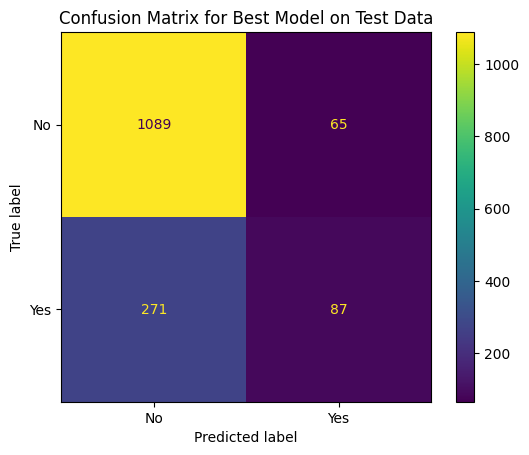

In [23]:
import matplotlib.pyplot as plt
# Predict on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title('Confusion Matrix for Best Model on Test Data')
plt.show()

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [32]:
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def custom_f1_scorer(y_true, y_pred):
    # Print unique predicted values to diagnose the issue
    print("Unique predicted values in fold:", np.unique(y_pred))
    # Calculate F1 score, handling potential errors if a class is missing
    return f1_score(y_true, y_pred, average='binary', pos_label='Yes', zero_division=0)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Added random_state for reproducibility

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(custom_f1_scorer, response_method='predict'), n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring=make_scorer(custom_f1_scorer, response_method='predict'),
             verbose=2)

In [28]:
# Display the best cross-validation F1 score found during GridSearchCV
print("\nModel's Estimated F1 Score (from Cross-Validation):")
print(grid_search.best_score_)

# The classification report also provides precision, recall, and f1-score for each class on the test set.
print("\nModel's Performance Metrics on Test Data:")
print(classification_report(y_test, y_pred))

# You can also extract the accuracy score from the classification report or by comparing y_test and y_pred
from sklearn.metrics import accuracy_score
print(f"\nModel's Accuracy on Test Data: {accuracy_score(y_test, y_pred):.4f}")



Model's Estimated F1 Score (from Cross-Validation):
nan

Model's Performance Metrics on Test Data:
              precision    recall  f1-score   support

          No       0.80      0.94      0.87      1154
         Yes       0.57      0.24      0.34       358

    accuracy                           0.78      1512
   macro avg       0.69      0.59      0.60      1512
weighted avg       0.75      0.78      0.74      1512


Model's Accuracy on Test Data: 0.7778


In [30]:
# Get the best cross-validation score (F1 score in this case, as specified in scoring='f1')
best_cv_score = grid_search.best_score_

# Print the best cross-validation score
print("Best cross-validation F1 score:", best_cv_score)

Best cross-validation F1 score: nan


In [34]:
# Make predictions on the unseen test data using the best model found by GridSearchCV
y_pred = grid_search.predict(X_test)

print("\nModel predictions on the unseen test data:")
y_pred


Model predictions on the unseen test data:


array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

In [35]:

print("\nClassification Report on Test Data (from best model):")
print(classification_report(y_test, y_pred))


Classification Report on Test Data (from best model):
              precision    recall  f1-score   support

          No       0.80      0.95      0.87      1154
         Yes       0.58      0.23      0.33       358

    accuracy                           0.78      1512
   macro avg       0.69      0.59      0.60      1512
weighted avg       0.75      0.78      0.74      1512



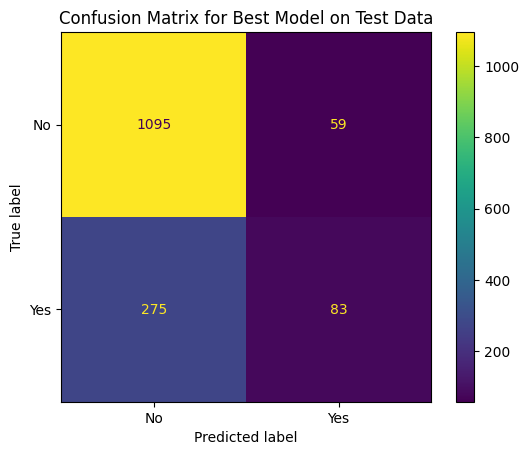

In [36]:
import matplotlib.pyplot as plt
# Plot the confusion matrix for the best model on the test data
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title('Confusion Matrix for Best Model on Test Data')
plt.show()


In [37]:
# Get the confusion matrix from the plot or the calculated variable
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Assuming 'Yes' is the positive class, which is at index 1 in the sorted class labels ['No', 'Yes']
# TP = cm[1, 1]
# FN = cm[1, 0]

TP = cm[1][1] # True Positives: Actual Yes, Predicted Yes
FN = cm[1][0] # False Negatives: Actual Yes, Predicted No

# Calculate True Positive Rate (Recall for 'Yes')
true_positive_rate = TP / (TP + FN)

print(f"True Positive Rate (Recall for 'Yes'): {true_positive_rate:.4f}")


True Positive Rate (Recall for 'Yes'): 0.2318



Feature Importances:
MaxTemp                           0.198253
MinTemp                           0.192230
Rainfall                          0.114764
cat__WindDir9am_N                 0.019562
cat__Location_MelbourneAirport    0.018467
cat__Location_Watsonia            0.017943
cat__WindGustDir_N                0.017856
cat__Location_Melbourne           0.017753
cat__Season_Spring                0.015696
cat__Season_Autumn                0.014613
cat__WindGustDir_SW               0.013650
cat__WindDir3pm_N                 0.013621
cat__WindDir3pm_SW                0.012701
cat__WindGustDir_W                0.012676
cat__Season_Winter                0.012616
cat__WindGustDir_WSW              0.012367
cat__WindDir3pm_S                 0.011923
cat__WindDir3pm_SSW               0.011837
cat__Season_Summer                0.011258
cat__WindDir9am_W                 0.010830
cat__WindDir3pm_NNW               0.010763
cat__WindDir9am_WSW               0.010705
cat__WindDir3pm_NNE             

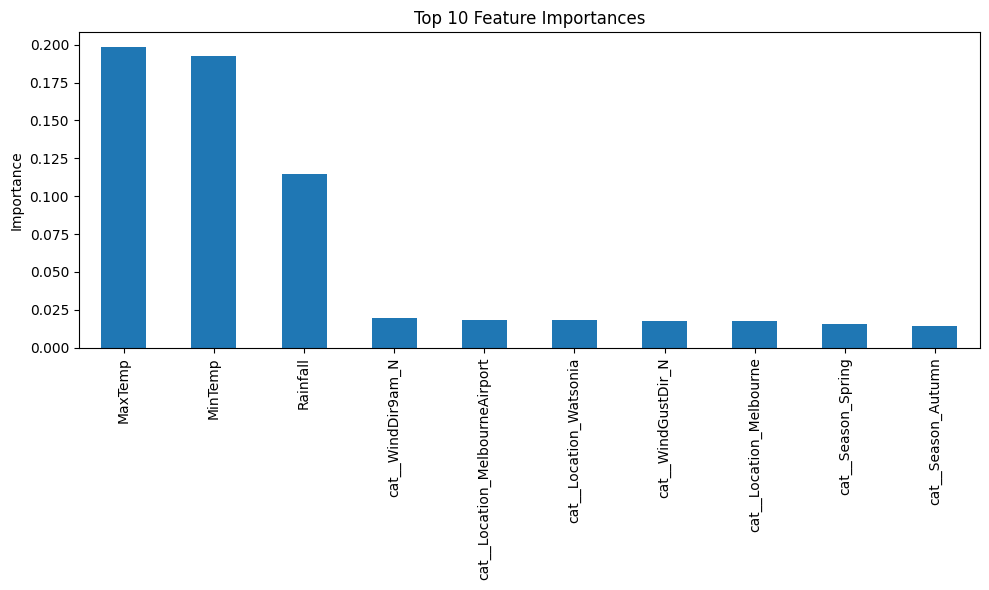

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
# Assuming 'best_model' is your fitted RandomForestClassifier pipeline
# Extract the trained Random Forest classifier from the pipeline
random_forest_classifier = best_model.named_steps['classifier']

# Get the feature importances
feature_importances = random_forest_classifier.feature_importances_

# Get the feature names after preprocessing
# The preprocessor step contains the column names
# We need to handle the one-hot encoded categorical features
ohe_categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_
categorical_feature_names = [f'cat__{col}_{cat}' for col, cats in zip(categorical_features, ohe_categories) for cat in cats]

# Combine numerical and one-hot encoded categorical feature names
all_feature_names = numerical_features.tolist() + categorical_feature_names

# Create a Series for easy visualization
feature_importance_series = pd.Series(feature_importances, index=all_feature_names)

# Sort the features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Print or visualize the feature importances
print("\nFeature Importances:")
print(sorted_feature_importances)

# Optional: Plot the top N feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

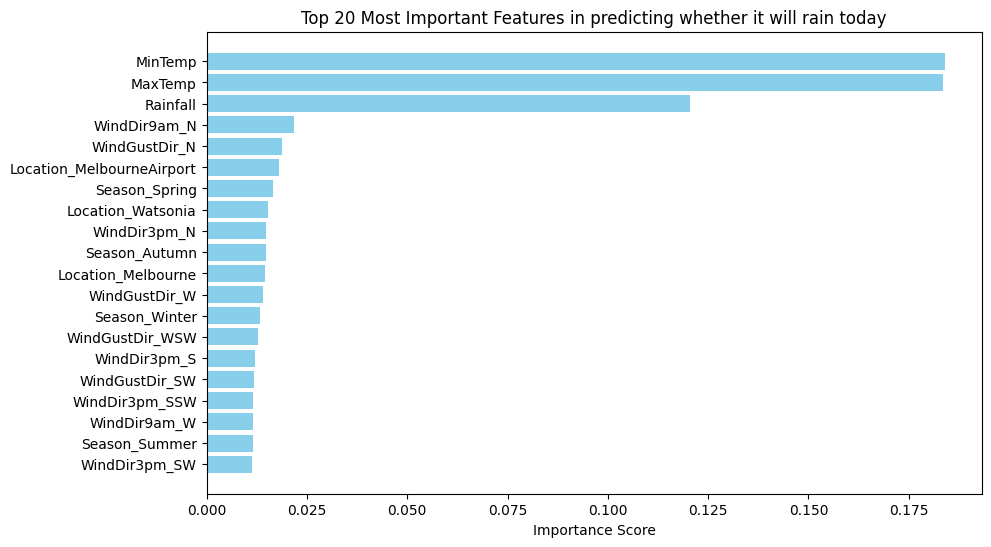

In [40]:
# Combine numeric and categorical feature names

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

feature_names = numerical_features.tolist() + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
Based on the bar graph generated by the provided code, the most important feature for predicting whether it will rain today (RainToday) is **Humidity3pm**.

In [41]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(random_state=42, solver='liblinear')) # Changed to Logistic Regression
                          ])

print("\nUpdated Pipeline created:")
print(pipeline)

# Update the parameter grid for Logistic Regression
# Logistic Regression typically doesn't have as many hyperparameters as RandomForestClassifier
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'classifier__penalty': ['l1', 'l2'] # Specify penalty (L1 or L2)
    # Note: 'l1' penalty only works with 'liblinear' and 'saga' solvers.
    # 'l2' works with all solvers. We used 'liblinear' in the pipeline.
}

print("\nUpdated Parameter Grid for Logistic Regression:")
param_grid


Updated Pipeline created:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MinTemp', 'MaxTemp', 'Rainfall'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season'], dtype='object'))])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

Updated Parameter Grid for Logistic Regression:


{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'classifier__penalty': ['l1', 'l2']}

              precision    recall  f1-score   support

          No       0.80      0.95      0.87      1154
         Yes       0.58      0.23      0.33       358

    accuracy                           0.78      1512
   macro avg       0.69      0.59      0.60      1512
weighted avg       0.75      0.78      0.74      1512



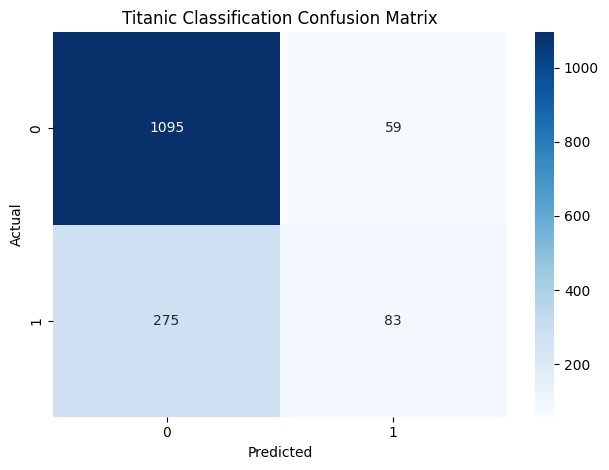

In [42]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Logistic Regression Results ---
Best parameters found by GridSearchCV (Logistic Regression):
{'classifier__C': 10, 'classifier__penalty': 'l2'}

Best cross-validation F1 score (Logistic Regression):
0.3766013888232842

Classification Report on Test Data (Logistic Regression):
              precision    recall  f1-score   support

          No       0.80      0.94      0.86      1154
         Yes       0.55      0.24      0.34       358

    accuracy                           0.77      1512
   macro avg       0.67      0.59      0.60      1512
weighted avg       0.74      0.77      0.74      1512


Accuracy on Test Data (Logistic Regression): 0.7731
True Positive Rate (Recall for 'Yes') on Test Data (Logistic Regression): 0.2430


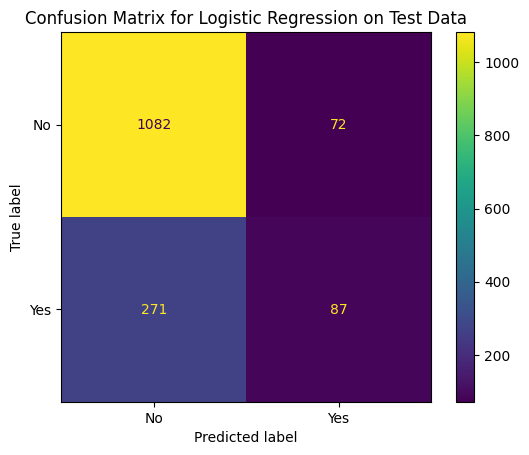


--- Random Forest Results (from previous run) ---

Classification Report on Test Data (Random Forest):
              precision    recall  f1-score   support

          No       0.80      0.95      0.87      1154
         Yes       0.58      0.23      0.33       358

    accuracy                           0.78      1512
   macro avg       0.69      0.59      0.60      1512
weighted avg       0.75      0.78      0.74      1512


Accuracy on Test Data (Random Forest): 0.7791
True Positive Rate (Recall for 'Yes') on Test Data (Random Forest): 0.2318


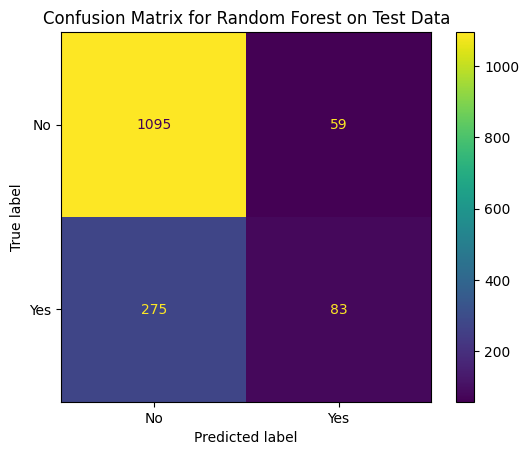


--- Comparison of Models ---
Comparison of Accuracy and True Positive Rate for Rainfall Predictions:
1.  Accuracy:
    -   Logistic Regression: 0.7731
    -   Random Forest: 0.7791
2.  True Positive Rate (Recall for 'Yes'):
    -   Logistic Regression: 0.2430
    -   Random Forest: 0.2318


In [44]:
import matplotlib.pyplot as plt
# --- Logistic Regression Evaluation ---
# Fit the grid search for Logistic Regression to the training data
# Use the same StratifiedKFold cross-validation
grid_search_lr = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(custom_f1_scorer, response_method='predict'), n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search_lr.fit(X_train, y_train)

print("\n--- Logistic Regression Results ---")
print("Best parameters found by GridSearchCV (Logistic Regression):")
print(grid_search_lr.best_params_)
print("\nBest cross-validation F1 score (Logistic Regression):")
print(grid_search_lr.best_score_)

# Get the best Logistic Regression model
best_model_lr = grid_search_lr.best_estimator_

# Predict on the test data using the best Logistic Regression model
y_pred_lr = best_model_lr.predict(X_test)

# Evaluate the best Logistic Regression model
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=best_model_lr.classes_)

# Calculate True Positive Rate for Logistic Regression
# Assuming 'Yes' is the positive class at index 1
TP_lr = cm_lr[1][1]
FN_lr = cm_lr[1][0]
true_positive_rate_lr = TP_lr / (TP_lr + FN_lr)

print("\nClassification Report on Test Data (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))
print(f"\nAccuracy on Test Data (Logistic Regression): {accuracy_lr:.4f}")
print(f"True Positive Rate (Recall for 'Yes') on Test Data (Logistic Regression): {true_positive_rate_lr:.4f}")

# Plot the confusion matrix for Logistic Regression
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=best_model_lr.classes_)
disp_lr.plot()
plt.title('Confusion Matrix for Logistic Regression on Test Data')
plt.show()


# --- Random Forest Evaluation (from previous code) ---
# We already have the results for the best Random Forest model (best_model)
# and its predictions (y_pred) from the previous code execution.
# We will use these variables to compare.

report_rf = classification_report(y_test, y_pred, output_dict=True)
accuracy_rf = accuracy_score(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Calculate True Positive Rate for Random Forest
# Assuming 'Yes' is the positive class at index 1
TP_rf = cm_rf[1][1]
FN_rf = cm_rf[1][0]
true_positive_rate_rf = TP_rf / (TP_rf + FN_rf)

print("\n--- Random Forest Results (from previous run) ---")
print("\nClassification Report on Test Data (Random Forest):")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy on Test Data (Random Forest): {accuracy_rf:.4f}")
print(f"True Positive Rate (Recall for 'Yes') on Test Data (Random Forest): {true_positive_rate_rf:.4f}")

# Plot the confusion matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_model.classes_)
disp_rf.plot()
plt.title('Confusion Matrix for Random Forest on Test Data')
plt.show()

# --- Comparison ---
print("\n--- Comparison of Models ---")
print("Comparison of Accuracy and True Positive Rate for Rainfall Predictions:")

comparison_results = [
    f"1.  Accuracy:",
    f"    -   Logistic Regression: {accuracy_lr:.4f}",
    f"    -   Random Forest: {accuracy_rf:.4f}",
    f"2.  True Positive Rate (Recall for 'Yes'):",
    f"    -   Logistic Regression: {true_positive_rate_lr:.4f}",
    f"    -   Random Forest: {true_positive_rate_rf:.4f}"
]

for result in comparison_results:
    print(result)

In [45]:
print(f"True Positive Rate (Recall for 'Yes') on Test Data (Random Forest): {true_positive_rate_rf:.4f}")
print(f"True Positive Rate (Recall for 'Yes') on Test Data (Logistic Regression): {true_positive_rate_lr:.4f}")

True Positive Rate (Recall for 'Yes') on Test Data (Random Forest): 0.2318
True Positive Rate (Recall for 'Yes') on Test Data (Logistic Regression): 0.2430
